[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/weaviate/recipes/blob/main/weaviate-features/multi-vector/multi-vector-colipali-rag.ipynb)

# Multimodal RAG over PDFs using ColQwen2, Qwen2.5, and Weaviate

This notebook demonstrates [Multimodal Retrieval-Augmented Generation (RAG)](https://weaviate.io/blog/multimodal-rag) over PDF documents.
We will be performing retrieval against a collection of PDF documents by embedding both the individual pages of the documents and our queries into the same multi-vector space, reducing the problem to approximate nearest-neighbor search on ColBERT-style multi-vector embeddings under the MaxSim similarity measure.

For this purpose, we will use

- **A multimodal [late-interaction model](https://weaviate.io/blog/late-interaction-overview)**, like ColPali and ColQwen2, to generate
embeddings. This tutorial uses the publicly available model
[ColQwen2-v1.0](https://huggingface.co/vidore/colqwen2-v1.0) with a permissive Apache 2.0 license.
- **A Weaviate [vector database](https://weaviate.io/blog/what-is-a-vector-database)**, which  has a [multi-vector feature](https://docs.weaviate.io/weaviate/tutorials/multi-vector-embeddings) to effectively index a collection of PDF documents and support textual queries against the contents of the documents, including both text and figures.
- **A vision language model (VLM)**, specifically [Qwen/Qwen2.5-VL-3B-Instruct](https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct), to support multimodal Retrieval-Augmented Generation (RAG).

Below, you can see the multimodal RAG system overview:

<img src="https://github.com/weaviate/recipes/blob/main/weaviate-features/multi-vector/figures/multimodal-rag-diagram.png?raw=1" width="700px"/>

First, the ingestion pipeline processes the PDF documents as images with the multimodal late-interaction model. The multi-vector embeddings are stored in a vector database.
Then at query time, the text query is processed by the same multimodal late-interaction model to retrieve the relevant documents.
The retrieved PDF files are then passed as visual context together with the original user query to the vision language model, which generates a response based on this information.


## Prerequisites

To run this notebook, you will need a machine capable of running neural networks using 5-10 GB of memory.
The demonstration uses two different vision language models that both require several gigabytes of memory.
See the documentation for each individual model and the general PyTorch docs to figure out how to best run the models on your hardware.

For example, you can run it on:

- Google Colab (using the free-tier T4 GPU)
- or locally (tested on an M2 Pro Mac).

Furthermore, you will need an instance of Weaviate version >= `1.29.0`.


## Step 1: Install required libraries

Let's begin by installing and importing the required libraries.

Note that you'll need Python `3.13`.

In [1]:
%%capture
%pip install colpali_engine weaviate-client qwen_vl_utils
%pip install -q -U "colpali-engine[interpretability]>=0.3.2,<0.4.0"

In [2]:
import os
import torch
import numpy as np

from google.colab import userdata
from datasets import load_dataset

from transformers.utils.import_utils import is_flash_attn_2_available
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor

from colpali_engine.models import ColQwen2, ColQwen2Processor
#from colpali_engine.models import ColPali, ColPaliProcessor # uncomment if you prefer to use ColPali models instead of ColQwen2 models

import weaviate
from weaviate.classes.init import Auth
import weaviate.classes.config as wc
from weaviate.classes.config import Configure
from weaviate.classes.query import MetadataQuery

from qwen_vl_utils import process_vision_info
import base64
from io import BytesIO

import matplotlib.pyplot as plt

from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)


## Step 2: Load the PDF dataset

Let's start with the data.
We're going to first load a PDF document dataset of the [top-40 most
cited AI papers on arXiv](https://arxiv.org/abs/2412.12121) from Hugging Face from the period 2023-01-01 to 2024-09-30.

In [3]:
dataset = load_dataset("weaviate/arXiv-AI-papers-multi-vector", split="train")

README.md:   0%|          | 0.00/530 [00:00<?, ?B/s]

n40_p10_images.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/399 [00:00<?, ? examples/s]

In [4]:
dataset

Dataset({
    features: ['page_id', 'paper_title', 'paper_arxiv_id', 'page_number', 'colqwen_embedding', 'page_image'],
    num_rows: 399
})

In [ ]:
dataset[398]

Let's take a look at a sample document page from the loaded PDF dataset.

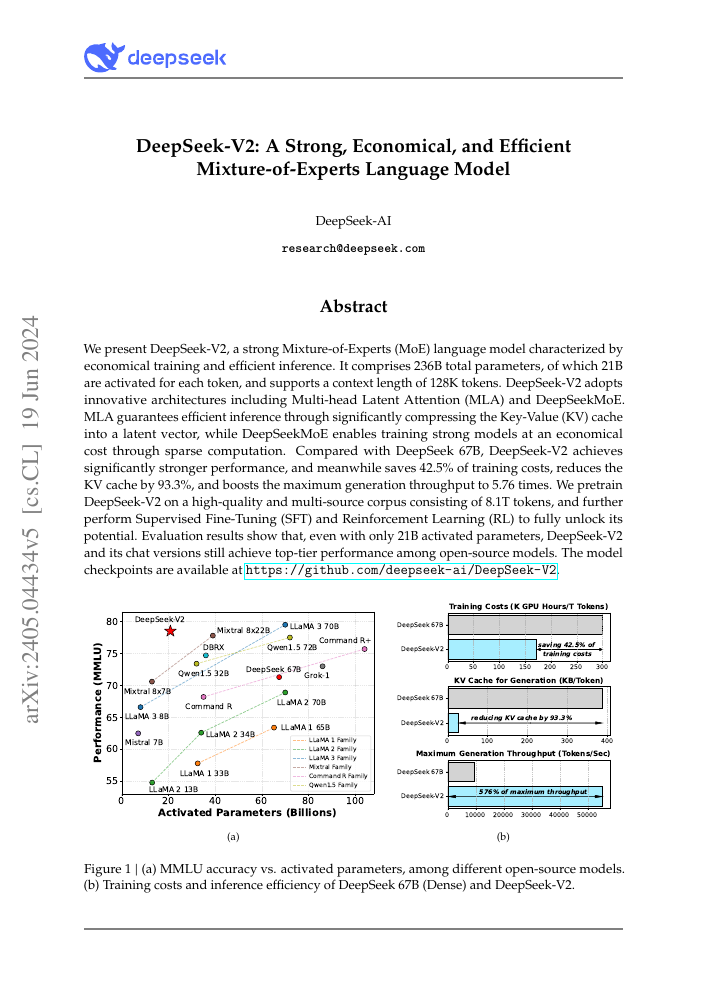

In [6]:
display(dataset[289]["page_image"])

## Step 3: Load the ColVision (ColPali or ColQwen2) model

The approach to generate embeddings for this tutorial is outlined in the paper [ColPali: Efficient Document Retrieval with Vision Language Models](https://arxiv.org/abs/2407.01449). The paper demonstrates that it is possible to simplify traditional approaches to preprocessing PDF documents for retrieval:

Traditional PDF processing in RAG systems involves using OCR (Optical Character Recognition) and layout detection software, and separate processing of text, tables, figures, and charts. Additionally, after text extraction, text processing also requires a chunking step. Instead, the ColPali method feeds images (screenshots) of entire PDF pages to a Vision Language Model that produces a ColBERT-style multi-vector embedding.

<img src="https://github.com/weaviate/recipes/blob/main/weaviate-features/multi-vector/figures/colipali_pipeline.jpeg?raw=1" width="700px"/>

There are different ColVision models, such as ColPali or ColQwen2, available, which mainly differ in the used encoders (Contextualized Late Interaction over Qwen2 vs. PaliGemma-3B). You can read more about the differences between ColPali and ColQwen2 in our [overview of late-interaction models](https://weaviate.io/blog/late-interaction-overview).

Let's load the [ColQwen2-v1.0](https://huggingface.co/vidore/colqwen2-v1.0) model for this tutorial.

In [7]:
# Get rid of process forking deadlock warnings.
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [8]:
if torch.cuda.is_available(): # If GPU available
    device = "cuda:0"
elif torch.backends.mps.is_available(): # If Apple Silicon available
    device = "mps"
else:
    device = "cpu"

if is_flash_attn_2_available():
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "eager"

print(f"Using device: {device}")
print(f"Using attention implementation: {attn_implementation}")

Using device: cuda:0
Using attention implementation: eager


In [9]:
model_name = "vidore/colqwen2-v1.0"

# About a 5 GB download and similar memory usage.
model = ColQwen2.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map=device,
    attn_implementation=attn_implementation,
).eval()

# Load processor
processor = ColQwen2Processor.from_pretrained(model_name)

adapter_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/74.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

This notebook uses the ColQwen2 model because it has a permissive Apache 2.0 license.
Alternatively, you can also use [ColPali](https://huggingface.co/vidore/colpali-v1.2), which has a Gemma license, or check out other available [ColVision models](https://github.com/illuin-tech/colpali). For a detailed comparison, you can also refer to [ViDoRe: The Visual Document Retrieval Benchmark](https://huggingface.co/spaces/vidore/vidore-leaderboard)

If you want to use ColPali instead of ColQwen2, you can comment out the above code cell and uncomment the code cell below.

In [10]:
#model_name = "vidore/colpali-v1.2"

# Load model
#colpali_model = ColPali.from_pretrained(
#    model_name,
#    torch_dtype=torch.bfloat16,
#    device_map=device,
#    attn_implementation=attn_implementation,
#).eval()

# Load processor
#colpali_processor = ColPaliProcessor.from_pretrained(model_name)

Before we go further, let's familiarize ourselves with the ColQwen2 model. It can create multi-vector embeddings from both images and text queries. Below you can see examples of each.


In [11]:
# Sample image inputs
images = [
    dataset[0]["page_image"],
    dataset[1]["page_image"],
]

# Process the inputs
batch_images = processor.process_images(images).to(model.device)

# Forward pass
with torch.no_grad():
    query_embedding = model(**batch_images)

print(query_embedding)
print(query_embedding.shape)

tensor([[[ 2.0630e-02, -8.6426e-02, -7.1289e-02,  ...,  5.1758e-02,
          -3.0365e-03,  1.1084e-01],
         [ 1.9409e-02, -1.0840e-01, -2.6245e-02,  ...,  7.6172e-02,
          -4.4922e-02, -1.3965e-01],
         [-1.7242e-03, -9.8145e-02, -1.9653e-02,  ...,  7.5684e-02,
          -3.3936e-02, -1.2891e-01],
         ...,
         [ 5.0537e-02, -1.0205e-01, -8.6426e-02,  ...,  4.9561e-02,
           3.1982e-02,  8.0078e-02],
         [ 3.9795e-02, -1.3477e-01, -5.0537e-02,  ...,  3.8330e-02,
          -6.1523e-02, -1.2012e-01],
         [ 9.3384e-03, -2.2168e-01, -1.4746e-01,  ..., -8.1177e-03,
          -5.2246e-02, -3.1128e-02]],

        [[ 2.0630e-02, -8.6426e-02, -7.1289e-02,  ...,  5.1758e-02,
          -3.0365e-03,  1.1084e-01],
         [ 1.9409e-02, -1.0840e-01, -2.6245e-02,  ...,  7.6172e-02,
          -4.4922e-02, -1.3965e-01],
         [-1.7242e-03, -9.8145e-02, -1.9653e-02,  ...,  7.5684e-02,
          -3.3936e-02, -1.2891e-01],
         ...,
         [ 7.2266e-02, -9

In [12]:
# Sample query inputs
queries = [
    "A table with LLM benchmark results.",
    "A figure detailing the architecture of a neural network.",
]

# Process the inputs
batch_queries = processor.process_queries(queries).to(model.device)

# Forward pass
with torch.no_grad():
    query_embedding = model(**batch_queries)

print(query_embedding)
print(query_embedding.shape)

tensor([[[ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0238, -0.0835, -0.0752,  ...,  0.0549,  0.0076,  0.0903],
         ...,
         [ 0.0559, -0.0457, -0.1118,  ..., -0.1621,  0.1758,  0.1011],
         [ 0.0525, -0.0376, -0.1172,  ..., -0.1572,  0.1787,  0.0938],
         [ 0.0486, -0.0294, -0.1250,  ..., -0.1494,  0.1797,  0.0918]],

        [[ 0.0238, -0.0835, -0.0752,  ...,  0.0549,  0.0076,  0.0903],
         [-0.0086, -0.1021, -0.0198,  ...,  0.0708, -0.0310, -0.1367],
         [-0.0864, -0.1230, -0.0222,  ...,  0.0776,  0.1040, -0.0128],
         ...,
         [-0.0544,  0.0310, -0.1318,  ..., -0.2236, -0.1445,  0.0381],
         [-0.0679,  0.0292, -0.1484,  ..., -0.2178, -0.1387,  0.0439],
         [-0.0742,  0.0291, -0.1553,  ..., -0.2109, -0.1289,  0.0452]]],
       device='cuda:0', dtype=torch.bfloat16)
torch.Size([2, 22, 128])


Let's write a class to wrap the multimodal late-interaction model and its embedding functionalities for convenience.



In [ ]:
# A convenience class to wrap the embedding functionality 
# of ColVision models like ColPali and ColQwen2 
class ColVision:
    def __init__(self, model, processor):
        """Initialize with a loaded model and processor."""
        self.model = model
        self.processor = processor

    # A batch size of one appears to be most performant when running on an M4.
    # Note: Reducing the image resolution speeds up the vectorizer and produces
    # fewer multi-vectors.
    def multi_vectorize_image(self, img):
        """Return the multi-vector image of the supplied PIL image."""
        image_batch = self.processor.process_images([img]).to(self.model.device)
        with torch.no_grad():
            image_embedding = self.model(**image_batch)
        return image_embedding[0]

    def multi_vectorize_text(self, query):
        """Return the multi-vector embedding of the query text string."""
        query_batch = self.processor.process_queries([query]).to(self.model.device)
        with torch.no_grad():
            query_embedding = self.model(**query_batch)
        return query_embedding[0]

# Instantiate the model to be used below.
colvision_embedder = ColVision(model, processor) # This will be instantiated after loading the model and processor

Let's verify that the embedding of images and queries works as intended.


In [14]:
# Sample image inputs
images = dataset[0]["page_image"]

page_embedding = colvision_embedder.multi_vectorize_image(images)
print(page_embedding.shape)  # torch.Size([755, 128])

queries = [
    "A table with LLM benchmark results.",
    "A figure detailing the architecture of a neural network.",
]

query_embeddings = [colvision_embedder.multi_vectorize_text(q) for q in queries]
print(query_embeddings[0].shape)  # torch.Size([20, 128])

torch.Size([755, 128])
torch.Size([20, 128])


## Step 4: Connect to a Weaviate vector database instance

Now, you will need to connect to a running Weaviate vector database cluster.

You can choose one of the following options:

1. **Option 1:** You can create a 14-day free sandbox on the managed service [Weaviate Cloud (WCD)](https://console.weaviate.cloud/)
2. **Option 2:** [Embedded Weaviate](https://weaviate.io/developers/weaviate/installation/embedded)
3. **Option 3:** [Local deployment](https://weaviate.io/developers/weaviate/installation/docker-compose#starter-docker-compose-file)
4. [Other options](https://weaviate.io/developers/weaviate/installation)

In [ ]:
# Option 1: Weaviate Cloud
WCD_URL = os.environ["WEAVIATE_URL"] # Replace with your Weaviate cluster URL
WCD_AUTH_KEY = os.environ["WEAVIATE_API_KEY"] # Replace with your cluster auth key

# Uncomment if you are working in a Google Colab environment
#WCD_URL = userdata.get("WEAVIATE_URL")
#WCD_AUTH_KEY = userdata.get("WEAVIATE_API_KEY")

# Weaviate Cloud Deployment
client = weaviate.connect_to_weaviate_cloud(
    cluster_url=WCD_URL,
    auth_credentials=weaviate.auth.AuthApiKey(WCD_AUTH_KEY),
)

# Option 2: Embedded Weaviate instance
# use if you want to explore Weaviate without any additional setup
#client = weaviate.connect_to_embedded()

# Option 3: Locally hosted instance of Weaviate via Docker or Kubernetes
#!docker run --detach -p 8080:8080 -p 50051:50051 cr.weaviate.io/semitechnologies/weaviate:1.29.0
#client = weaviate.connect_to_local()

print(client.is_ready())

True


For this tutorial, you will need the Weaviate `v1.29.0` or higher.
Let's make sure we have the required version:

In [16]:
client.get_meta()['version']

'1.32.4'

## Step 5: Create a collection

Next, we will create a collection that will hold the embeddings of the images of the PDF document pages.

We will not define a built-in vectorizer but use the [Bring Your Own Vectors (BYOV) approach](https://docs.weaviate.io/weaviate/starter-guides/custom-vectors), where we manually embed queries and PDF documents at ingestions and query stage.

Additionally, if you are interested in using the [MUVERA encoding algorithm](https://weaviate.io/blog/muvera) for multi-vector embeddings, you can uncomment it in the code below.

In [17]:
collection_name = "PDFDocuments"

In [18]:
# Delete the collection if it already exists
# Note: in practice, you shouldn't rerun this cell, as it deletes your data
# in "PDFDocuments", and then you need to re-import it again.
#if client.collections.exists(collection_name):
#  client.collections.delete(collection_name)

# Create a collection
collection = client.collections.create(
    name=collection_name,
    properties=[
        wc.Property(name="page_id", data_type=wc.DataType.INT),
        wc.Property(name="dataset_index", data_type=wc.DataType.INT),
        wc.Property(name="paper_title", data_type=wc.DataType.TEXT),
        wc.Property(name="paper_arxiv_id", data_type=wc.DataType.TEXT),
        wc.Property(name="page_number", data_type=wc.DataType.INT),
    ],
    vector_config=[
        Configure.MultiVectors.self_provided(
            name="colqwen",
            #encoding=Configure.VectorIndex.MultiVector.Encoding.muvera(),
            vector_index_config=Configure.VectorIndex.hnsw(
                multi_vector=Configure.VectorIndex.MultiVector.multi_vector()
            )
    )]
)

## Step 6: Uploading the vectors to Weaviate

In this step, we're indexing the vectors into our Weaviate Collection in batches.

For each batch, the images are processed and encoded using the ColPali model, turning them into multi-vector embeddings.
These embeddings are then converted from tensors into lists of vectors, capturing key details from each image and creating a multi-vector representation for each document.
This setup works well with Weaviate's multivector capabilities.

After processing, the vectors and any metadata are uploaded to Weaviate, gradually building up the index.
You can lower or increase the `batch_size` depending on your available GPU resources.

In [19]:
# Map of page ids to images to support displaying the image corresponding to a
# particular page id.
page_images = {}

with collection.batch.dynamic() as batch:
    for i in range(len(dataset)):
        p = dataset[i]
        page_images[p["page_id"]] = p["page_image"]

        batch.add_object(
            properties={
                "page_id": p["page_id"],
                "paper_title": p["paper_title"],
                "paper_arxiv_id": p["paper_arxiv_id"],
                "page_number": p["page_number"],
                },
            vector={"colqwen": colvision_embedder.multi_vectorize_image(p["page_image"]).cpu().float().numpy().tolist()})

        if i % 25 == 0:
            print(f"Added {i+1}/{len(dataset)} Page objects to Weaviate.")

    batch.flush()

# Delete dataset after creating page_images dict to hold the images
del dataset

Added 1/399 Page objects to Weaviate.
Added 26/399 Page objects to Weaviate.
Added 51/399 Page objects to Weaviate.
Added 76/399 Page objects to Weaviate.
Added 101/399 Page objects to Weaviate.
Added 126/399 Page objects to Weaviate.
Added 151/399 Page objects to Weaviate.
Added 176/399 Page objects to Weaviate.
Added 201/399 Page objects to Weaviate.
Added 226/399 Page objects to Weaviate.
Added 251/399 Page objects to Weaviate.
Added 276/399 Page objects to Weaviate.
Added 301/399 Page objects to Weaviate.
Added 326/399 Page objects to Weaviate.
Added 351/399 Page objects to Weaviate.
Added 376/399 Page objects to Weaviate.


In [20]:
len(collection)

399

## Step 7: Multimodal Retrieval Query

As an example of what we are going to build, consider the following actual demo query and resulting PDF page from our collection (nearest neighbor):

- Query: "How does DeepSeek-V2 compare against the LLaMA family of LLMs?"
- Nearest neighbor:  "DeepSeek-V2: A Strong Economical and Efficient Mixture-of-Experts Language Model" (arXiv: 2405.04434), Page: 1.


In [ ]:
query = "How does DeepSeek-V2 compare against the LLaMA family of LLMs?"

: 

By inspecting the first page of the [DeepSeek-V2 paper](https://arxiv.org/abs/2405.04434), we see that it does indeed contain a figure that is relevant for answering our query:

<img src="https://github.com/weaviate/recipes/blob/main/weaviate-features/multi-vector/figures/deepseek_efficiency.jpeg?raw=1" width="700px"/>

Note: To avoid `OutOfMemoryError` on freely available resources like Google Colab, we will only retrieve a single document. If you have resources with more memory available, you can set the `limit`parameter to a higher value, like e.g., `limit=3` to increase the number of retrieved PDF pages.

In [ ]:
response = collection.query.near_vector(
    near_vector=colvision_embedder.multi_vectorize_text(query).cpu().float().numpy(),
    target_vector="colqwen",
    limit=1,
    return_metadata=MetadataQuery(distance=True), # Needed to return MaxSim score
)

print(f"The most relevant documents for the query \"{query}\" by order of relevance:\n")
result_images = []
for i, o in enumerate(response.objects):
    p = o.properties
    print(
        f"{i+1}) MaxSim: {-o.metadata.distance:.2f}, "
        + f"Title: \"{p['paper_title']}\" "
        + f"(arXiv: {p['paper_arxiv_id']}), "
        + f"Page: {int(p['page_number'])}"
    )
    result_images.append(page_images[p["page_id"]])

The most relevant documents for the query "How does DeepSeek-V2 compare against the LLaMA family of LLMs?" by order of relevance:

1) MaxSim: 23.12, Title: "DeepSeek-V2: A Strong Economical and Efficient Mixture-of-Experts Language Model" (arXiv: 2405.04434), Page: 1


The retrieved page with the highest MaxSim score is indeed the page with the figure we mentioned earlier.

In [23]:
closest_page_id = response.objects[0].properties['page_id']
image = page_images[closest_page_id]
display(image)

![Retrieved page](./figures/retrieved_page.png)

Let's visualize the similarity maps for the retrieved PDF document page to see the semantic similarity between each token in the user query and the image patches. This is an optional step.

In [ ]:

# Preprocess inputs
batch_images = processor.process_images([image]).to(device)
batch_queries = processor.process_queries([query]).to(device)

# Forward passes
with torch.no_grad():
    image_embeddings = model.forward(**batch_images)
    query_embeddings = model.forward(**batch_queries)

# Get the number of image patches
n_patches = processor.get_n_patches(
    image_size=image.size,
    spatial_merge_size=model.spatial_merge_size,
)

# Get the tensor mask to filter out the embeddings that are not related to the image
image_mask = processor.get_image_mask(batch_images)

# Generate the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embeddings,
    query_embeddings=query_embeddings,
    n_patches=n_patches,
    image_mask=image_mask,
)

# Get the similarity map for our (only) input image
similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)

print(f"Similarity map shape: (query_length, n_patches_x, n_patches_y) = {tuple(similarity_maps.shape)}")

In [ ]:
# Remove the padding tokens and the query augmentation tokens
query_content = processor.decode(batch_queries.input_ids[0])
query_content = query_content.replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()

# Retokenize the cleaned query
query_tokens = processor.tokenizer.tokenize(query_content)

# Use this cell output to choose a token using its index
for idex, val in enumerate(query_tokens):
    print(f"{idex}: {val}")

Let's check the similarity plot for the token "MA" in "LLaMA". (Note that similarity maps are created for each token separately.)

In [ ]:
token_idx = 13

fig, ax = plot_similarity_map(
    image=image,
    similarity_map=similarity_maps[token_idx],
    figsize=(18, 18),
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

plt.show()

![Similarity map](./figures/similarity_map.png)

In [ ]:
# Delete variables used for visualization
del batched_similarity_maps, similarity_maps, n_patches, query_content, query_tokens, token_idx

## Step 8: Extension to Multimodal RAG using Qwen2.5

The above example gives us the most relevant pages to begin looking at to answer our query. Let's extend this multimodal document retrieval pipeline to a multimodal RAG pipeline.

Vision language models (VLMs) are Large Language Models with vision capabilities. They are now powerful enough that we can give the query and relevant pages to such a model and have it produce an answer to our query in plain text.

To accomplish this we are going to feed the top results into the
state-of-the-art VLM [Qwen/Qwen2.5-VL-3B-Instruct](https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct).

In [ ]:
# Setting up Qwen2.5-VL-3B-Instruct for generating answers from a query string
# plus a collection of (images of) PDF pages.

class QwenVL:
    def __init__(self):
        # Adjust the settings to your available architecture, see the link
        # https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct for examples.
        self.model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            "Qwen/Qwen2.5-VL-3B-Instruct",
            torch_dtype=torch.bfloat16,
            device_map=device,
            attn_implementation=attn_implementation,
        )

        min_pixels = 256*28*28
        max_pixels = 1280*28*28
        self.processor = AutoProcessor.from_pretrained(
            "Qwen/Qwen2.5-VL-3B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

    def query_images(self, query, images):
        """Generate a textual response to the query (text) based on the information in the supplied list of PIL images."""
        # Preparation for inference.
        # Convert the images to base64 strings.
        content = []

        for img in images:
            buffer = BytesIO()
            img.save(buffer, format="jpeg")
            img_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
            content.append({"type": "image", "image": f"data:image;base64,{img_base64}"})

        content.append({"type": "text", "text": query})
        messages = [{"role": "user", "content": content}]

        text = self.processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        image_inputs, video_inputs = process_vision_info(messages)
        inputs = self.processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to(device)

        # Inference: Generation of the output.
        generated_ids = self.model.generate(**inputs, max_new_tokens=128)
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        return self.processor.batch_decode(
            generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )[0]

# Instantiate the model to be used below.
qwenvl = QwenVL()

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

The response from `Qwen2.5-VL-3B-Instruct` based on the retrieved PDF pages:

In [30]:
qwenvl.query_images(query, result_images)

'DeepSeek-V2 achieves significantly stronger performance than the LLaMA family of LLMs, while also saving 42.5% of training costs and boosting the maximum generation throughput to 5.76 times.'

As you can see, the multimodal RAG pipeline was able to answer the original query: "How does DeepSeek-V2 compare against the LLaMA family of LLMs?". For this, the ColQwen2 retrieval model retrieved the correct PDF page from the 
"DeepSeek-V2: A Strong Economical and Efficient Mixture-of-Experts Language Model" paper and used both the text and visual from the retrieved PDF page to answer the question.

## Summary

This notebook demonstrates a multimodal RAG pipeline over PDF documents using ColQwen2 for multi-vector embeddings, a Weaviate vector database for storage and retrieval, and Qwen2.5-VL-3B-Instruct for generating answers.

## References

- Faysse, M., Sibille, H., Wu, T., Omrani, B., Viaud, G., Hudelot, C., Colombo, P. (2024). ColPali: Efficient Document Retrieval with Vision Language Models. arXiv. https://doi.org/10.48550/arXiv.2407.01449
- [ColPali GitHub repository](https://github.com/illuin-tech/colpali)
- [ColPali Cookbook](https://github.com/tonywu71/colpali-cookbooks)